<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> Приветствую, мой Ревью! Хочу заранее предупредить, что проект долго запускается - примерно 30 минут. Все из-за BERT )), с учетом подбора очень скромных гиперпараметров!

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# Содержание <a id='0.0'></a>

<a href='#1.1'>1. Подготовка и обработка текста'</a>
 
<a href='#1.2'>2. Обучение моделей и подбор гиперпараметров'</a>

 - <a href='#1.3'>2.1 Создание функций и параметров моделей'</a>
 - <a href='#1.4'>2.2 Признаки для моделей'</a>
 - <a href='#1.5'>2.3 Признаки для модели Bert'</a>
 - <a href='#1.6'>2.4 Подбор гиперпараметров для моделей'</a>

<a href='#1.7'>3. Тестирование'</a>

<a href='#1.8'>4. Выводы'</a>


# 1. Подготовка и обработка текста <a id='1.1'></a>

In [555]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp
from pymystem3 import Mystem
import re
import torch
import transformers as tf
from tqdm import notebook
import nltk
from sklearn.dummy import DummyRegressor
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.metrics import f1_score,confusion_matrix,roc_auc_score,make_scorer,precision_score,roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
# Импортируем необходимые библиотеки.

In [556]:
# Так же загрузим словари стоп-слов из библиотеки nltk и определим язык словоря.
warnings.filterwarnings("ignore")
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kazbek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [557]:
# чтение файла. Просмотрим общий вид таблиц и инфу по файлу.
#comments = pd.read_csv('/Users/kazbek/Desktop/Python/Payton/DS - обучение/Курс 10_Машинное обучение для текстов/toxic_comments.csv')
comments = pd.read_csv('/datasets/toxic_comments.csv')
display(comments.head())
display(comments.info())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

0    143346
1     16225
Name: toxic, dtype: int64

In [609]:
# Проверим наличие пропусков, дубликатов и количество негативных и позитивных комментариев.
display('Количество позитивных и негативных комментариев - {}'.format(comments['toxic'].value_counts()))
display('Количество пропусков - {}'.format(comments.isna().sum()))
display('Количество дубликатов - {}'.format(comments.duplicated().sum()))

'Количество позитивных и негативных комментариев - 0    143346\n1     16225\nName: toxic, dtype: int64'

'Количество пропусков - text     0\ntoxic    0\ndtype: int64'

'Количество дубликатов - 0'

In [558]:
# Методом astype переведём тексты в стандартный для Python формат: кодировку Unicode (U).
corpus = comments['text'].values.astype('U')

In [559]:
# Посмотрим первые 5 комментов в исходном состоянии
display(corpus[0:5])

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       '"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences f

In [560]:
# Создадим функцию, которая обрабатывает текст возвращая лемму каждого слова без знаков препинания и цифр
def word_processing(text):
    m = Mystem()
    # Создадим класс для лемматизации:
    clear_text = []
    for strings in text:
        lemm_strings = m.lemmatize(strings)
        # возвращаем лемму каждого слова
        lemm_list = "".join(lemm_strings)
        sub_strings = re.sub(r"[^a-zA-Z']", " ", lemm_list.lower())
        # оставим слова без знаков препинания и цифр
        clear_text.append(" ".join(sub_strings.split()))
        # Функцией join() объединим элементы списка в строку, разделив их пробелом
    return clear_text
        
clear_comments = word_processing(corpus)
# Посмотрим первые 5 комментов после обработки
display(clear_comments[0:5])

["explanation why the edits made under my username hardcore metallica fan were reverted they weren't vandalisms just closure on some gas after i voted at new york dolls fac and please don't remove the template from the talk page since i'm retired now",
 "d'aww he matches this background colour i'm seemingly stuck with thanks talk january utc",
 "hey man i'm really not trying to edit war it's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info",
 "more i can't make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there ap

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> В датасете 159 571 записей и 2 столбца, тип данных (целочисленный и строчный).Два признака - комментарии пользователей и классификатор тональности комментария(целевой признак). Дубликатов и пропусков в датасете нет.Количество позитивных комментариев - 90%, и негативных комментариев - 10%.
В ходе обработке текста было сделано:
- перевели тексты в стандартный для Python формат(Unicode)
- провели лемматизацию текста с помощью библиотеки pymystem3
- через модуль re и при помощи функцией re.sub() написали регулярное выражени -  оставить только латинские символы,пробелы и апостроф. 
- удалили лишние пробелы методом split().
- перевели текст в нижний регистр методом lower().

<a href='#0.0'>Содержание'</a>

# 2. Обучение моделей и подбор гиперпараметров <a id='1.2'></a>

### 2.1 Создание функций и праметров <a id='1.3'></a>

In [561]:
# Сохраним значение random_state в переменной rs
rs=12345
scorer = make_scorer(f1_score,greater_is_better=False)

In [562]:
# Создадим функцию для пременения способа GridSearchCV для нахождения и сохранения лучших параметров модели
def best_parameters(Regressor,features,target,param):
    model = GridSearchCV(estimator=Regressor, param_grid=param, cv=3, n_jobs=-1)
    model.fit(features, target)
    display(f'Лучшие параметры: {model.best_params_}')
    pred = model.predict(features)
    display("Показатель F1  - наилучшей модели на валидационной выборке: {:.4f}".format(f1_score(target, pred)))
    display("Матрица неточностей: {}".format(confusion_matrix(target,pred)))
    prob = model.predict_proba(features)
    prob_one = prob[:, 1] 
    display("Оценка ROC-AUC: {:.4f}".format(roc_auc_score(target, prob_one)))
    return model.best_estimator_

In [563]:
# Создадим функцию для вывода матрицы неточности моделей
def matrix(model,features,target):
    fig = plt.figure(figsize=(6,4))
    plt.title('Матрица неточностей')
    pred = model.predict(features)
    cm = confusion_matrix(target,pred)
    sns.heatmap(cm,annot=True,cmap='coolwarm',linewidths=0.7,fmt = '.0f')
    plt.ylabel('Целевой признак')
    plt.xlabel('Предсказания')
    plt.show()

In [564]:
# Создадим функцию для нахождения и сохранения метрики качества на тестовой выборке и определения времени обучения и предсказания
def score(model,f_test,t_test):
    pred = model.predict(f_test)
    prob = model.predict_proba(f_test)
    prob_one = prob[:, 1]
    f1 = f1_score(t_test, pred)
    roc_auc = roc_auc_score(t_test, prob_one)
    display(f'Метрики качества модели F1: {f1}')
    display("Оценка ROC-AUC: {:.4f}".format(roc_auc_score(t_test, prob_one)))
    return f1, roc_auc

In [565]:
# Запишем параметры,которые мы хотим перебрать для разных моделей в отдельные переменные 
param_forest = {'n_estimators': range(5, 80, 5),'max_depth': range(1,8,2)}

param_log = {'penalty': ['l1', 'l2'],'C': [0.001, 0.01, 0.1, 1, 10, 50]}

param_gbc = {'n_estimators' : [100,200],'learning_rate':[0.1,0.5]}

param_sgd = {'alpha' : [1, 1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06],'penalty' : ['l1','l2'],}

In [566]:
#Создадим функцию создания эмбеддинги для комментариев , ограничив размер батча 25 объектами
def creating_embeddings (padded,attention_mask): 
    batch_size = 50
    embeddings = []
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
            batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
            attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

            with torch.no_grad():
                batch_embeddings = model(batch, attention_mask=attention_mask_batch)

            embeddings.append(batch_embeddings[0][:,0,:].numpy())
    return embeddings

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> Создали один блог для всех крупных функций, которые нам понадобятся в этом проекте, мне кажется , так будет удобно, и можно добавлять функции в этот блог, если в этом будет потребност. Так же в этом блоге укажем параметры для моделей и какие-то константные переменные.

<a href='#0.0'>Содержание'</a>

### 2.2 Признаки для моделей <a id='1.4'></a>

In [567]:
# Разделим наши данные на обучающую и тестовую выборки методом train_test_split в соотношении 75:25
target = comments['toxic']
features = clear_comments
f_train, f_test, t_train, t_test = train_test_split(features, target, test_size=0.25, random_state=rs)

'Дисбаланс классов:'

0    0.898321
1    0.101679
Name: toxic, dtype: float64

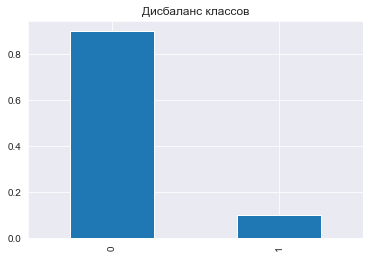

In [633]:
# Определим дисбаланс классов и построим барный график
class_frequency = target.value_counts(normalize=True) 
display("Дисбаланс классов:")
display(class_frequency)
class_frequency.plot(kind='bar',grid=True,title = 'Дисбаланс классов');

In [569]:
# класс TfidfVectorizer() создадим счётчик, указав в нём стоп-слова:
count_tf_idf = TfidfVectorizer(max_df=0.7, stop_words=stopwords)
#Чтобы посчитать TF-IDF для корпуса текстов, вызовем функцию fit_transform():
tf_idf = count_tf_idf.fit_transform(f_train)
# разделены на обучающую и тестовую выборки, функцию fit() запускайте только на обучающей. 
tf_idf_test = count_tf_idf.transform(f_test)

In [570]:
# Размеры обучающей и тестовой выборки
display('Размер обучающей выборки: {} объектов, {} признаков'.format(tf_idf.shape[0], tf_idf.shape[1]))
display('Размер тестовой выборки: {} объектов, {} признаков'.format(tf_idf_test.shape[0], tf_idf_test.shape[1]))

'Размер обучающей выборки: 119678 объектов, 144264 признаков'

'Размер тестовой выборки: 39893 объектов, 144264 признаков'

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> При получении признаков для обучения моделей, разделили наши данные на обучающую и тестовую выборки в соотношении 75:25. Посмотрели на дисбаланс классов. Перевели тексты в понятный для машины формат — векторный. Преобразовывали слова в векторы моделью TF-IDF из библиотеки sklearn при помощи класса TfidfVectorizer().Так как данные разделены на обучающую и тестовую выборки, функцию fit() запускалась только на обучающей. Для того, чтобы тестирование было честным: в модели не будут учтены частоты слов из тестовой выборки. У нас получилось 119678 строк и 144264 столбцов.
    
Посмотрели на дисбаланс классов - данные остались несбалансированны. Для улучшеная качества моделей при дисбалансе классов можно использовать четыре технологии: upsampling, downsampling, изменения веса классов параметром class_weight и технику вычисления вероятностей классов изменяя порог классов. Мы воспользуемся - class_weight

<a href='#0.0'>Содержание'</a>

### 2.3 Признаки для модели Bert <a id='1.5'></a>

In [571]:
# для проверки возьмем только 2000 случайных комментариев
df_bert = comments.sample(2000).reset_index(drop=True)

'Дисбаланс классов:'

0    0.8985
1    0.1015
Name: toxic, dtype: float64

<AxesSubplot:title={'center':'Дисбаланс классов'}>

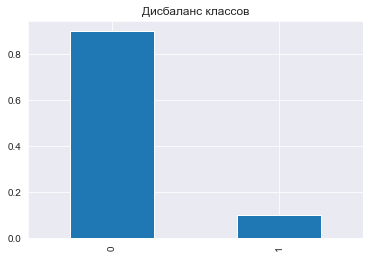

In [572]:
# Определим дисбаланс классов и построим барный график
class_frequency = df_bert['toxic'].value_counts(normalize=True) 
display("Дисбаланс классов:")
display(class_frequency)
class_frequency.plot(kind='bar',grid=True,title = 'Дисбаланс классов') 

In [573]:
#Загрузим предобученную модели DistilBERT и токенизато
model_bert, tokenizer_bert, config_bert, pretrained_weights = (tf.DistilBertModel,
                                                               tf.DistilBertTokenizer,
                                                               tf.DistilBertConfig,
                                                               'distilbert-base-uncased')
tokenizer = tokenizer_bert.from_pretrained(pretrained_weights)
configuration = config_bert.from_pretrained(pretrained_weights)
model = model_bert.from_pretrained(pretrained_weights, config = configuration)

In [574]:
# токенизируем текст - используя уже готовый трансформатор текста, укажем максимальную длину твитов = 512
tokenized = df_bert['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True,
                                                             truncation=True,max_length = 512))
max_len = 0
for i in notebook.tqdm(tokenized.values):
    if len(i) > max_len:
        max_len = len(i)
# Применим метод padding (англ. «отступ»), чтобы после токенизации длины исходных текстов в корпусе были равными. 
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
# «создадим маску» для действительно важных токенов, то есть укажем нулевые и не нулевые значения:
attention_mask = np.where(padded != 0, 1, 0)

In [575]:
# Посмотрим какая получилась длина
display(padded.shape)
display(attention_mask.shape)

(2000, 512)

(2000, 512)

In [576]:
# Применим функцию получения embeddings
embeddings = creating_embeddings(padded,attention_mask)

In [577]:
#Запишем все эмбеддинги в матрицу признаков, выделим целевой признак.
features_bert = np.concatenate(embeddings)
target_bert = df_bert['toxic']

# Разделим наши данные на обучающую и тестовую выборки методом rain_test_split в соотношении 70:30
f_train_bert, f_test_bert, t_train_bert, t_test_bert = train_test_split(features_bert, target_bert, test_size=0.30, random_state=rs)

In [578]:
# Размеры обучающей и тестовой выборки
display('Размер обучающей выборки: {} объектов, {} признаков'.format(f_train_bert.shape[0], f_train_bert.shape[1]))
display('Размер тестовой выборки: {} объектов, {} признаков'.format(f_test_bert.shape[0], f_test_bert.shape[1]))

'Размер обучающей выборки: 1400 объектов, 768 признаков'

'Размер тестовой выборки: 600 объектов, 768 признаков'

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> Для получении признаков для обучения моделей использовали уже предобученную на большом корпусе модель DistilBert.У DistilBERT улучшает скорость вывода. Нам нужна более быстрая скорость выведения, и поэтому остановимся на DistilBERT -  является разумным выбором, однако, мы потеряем лучшие метрики прогнозирования. Думаю, для целей проекта подойдет DistilBERT, так как, основная задача проекта научить нас использовать модели Bert - а  DistilBERT ее упрощенный аналог.
    
Из-за того, что получение embeddings на большой выборке занимает очень много времени(около 20-30 часов), мы возьмем для проверки только 2000 случайных комментариев. Можно предположить, что в среднем наша выборка будет стремиться к генеральной совокупности. Разделили наши данные на обучающую и тестовую выборки в соотношении 70:30. Провели токеннизацию с помощью модели DistilBERT.
    
Посмотрели на дисбаланс классов - данные остались несбалансированны. Для улучшеная качества моделей при дисбалансе классов можно использовать четыре технологии: upsampling, downsampling, изменения веса классов параметром class_weight и технику вычисления вероятностей классов изменяя порог классов. Мы воспользуемся - class_weight
    
Перевели тексты в понятный для машины формат — векторный. У нас получилось 1400 строк и 768 столбцов.

<a href='#0.0'>Содержание'</a>

### 2.4 Подбор гиперпараметров для моделей <a id='1.6'></a>

In [579]:
display('Модель LogisticRegression на преобученной модели DistilBert:')
log_model_bert = best_parameters(LogisticRegression(random_state=rs,class_weight='balanced'),f_train_bert,t_train_bert,param_log)

'Модель LogisticRegression на преобученной модели DistilBert:'

"Лучшие параметры: {'C': 10, 'penalty': 'l2'}"

'Показатель F1  - наилучшей модели на валидационной выборке: 0.9779'

'Матрица неточностей: [[1261    6]\n [   0  133]]'

'Оценка ROC-AUC: 1.0000'

In [580]:
display('Модель LogisticRegression:')
log_model = best_parameters(LogisticRegression(random_state=rs,class_weight='balanced'),tf_idf,t_train,param_log)

'Модель LogisticRegression:'

"Лучшие параметры: {'C': 50, 'penalty': 'l2'}"

'Показатель F1  - наилучшей модели на валидационной выборке: 0.9511'

'Матрица неточностей: [[106318   1222]\n [    23  12115]]'

'Оценка ROC-AUC: 0.9990'

In [581]:
display('Модель RandomForestClassifier на преобученной модели DistilBert:')
forest_model_bert = best_parameters(RandomForestClassifier(random_state=rs,class_weight='balanced'),f_train_bert,t_train_bert,param_forest)


'Модель RandomForestClassifier на преобученной модели DistilBert:'

"Лучшие параметры: {'max_depth': 5, 'n_estimators': 20}"

'Показатель F1  - наилучшей модели на валидационной выборке: 0.9034'

'Матрица неточностей: [[1241   26]\n [   2  131]]'

'Оценка ROC-AUC: 0.9966'

In [582]:
display('Модель RandomForestClassifier:')
forest_model = best_parameters(RandomForestClassifier(random_state=rs,class_weight='balanced'),tf_idf,t_train,param_forest)


'Модель RandomForestClassifier:'

"Лучшие параметры: {'max_depth': 7, 'n_estimators': 75}"

'Показатель F1  - наилучшей модели на валидационной выборке: 0.3608'

'Матрица неточностей: [[71219 36321]\n [ 1473 10665]]'

'Оценка ROC-AUC: 0.8883'

In [583]:
display('Модель GradientBoostingClassifier на преобученной модели DistilBert:')
gbc_model_bert = best_parameters(GradientBoostingClassifier(random_state=rs),f_train_bert,t_train_bert,param_gbc)


'Модель GradientBoostingClassifier на преобученной модели DistilBert:'

"Лучшие параметры: {'learning_rate': 0.1, 'n_estimators': 100}"

'Показатель F1  - наилучшей модели на валидационной выборке: 1.0000'

'Матрица неточностей: [[1267    0]\n [   0  133]]'

'Оценка ROC-AUC: 1.0000'

In [584]:
display('Модель GradientBoostingClassifier:')
gbc_model = best_parameters(GradientBoostingClassifier(),tf_idf,t_train,param_gbc)


'Модель GradientBoostingClassifier:'

"Лучшие параметры: {'learning_rate': 0.5, 'n_estimators': 100}"

'Показатель F1  - наилучшей модели на валидационной выборке: 0.7933'

'Матрица неточностей: [[106712    828]\n [  3614   8524]]'

'Оценка ROC-AUC: 0.9508'

In [585]:
display('Модель SGDClassifier на преобученной модели DistilBert:')
sgd_model_bert = best_parameters(SGDClassifier(random_state=rs,loss = 'log',class_weight='balanced'),f_train_bert,t_train_bert,param_sgd)

'Модель SGDClassifier на преобученной модели DistilBert:'

"Лучшие параметры: {'alpha': 1e-06, 'penalty': 'l1'}"

'Показатель F1  - наилучшей модели на валидационной выборке: 0.9399'

'Матрица неточностей: [[1250   17]\n [   0  133]]'

'Оценка ROC-AUC: 0.9933'

In [586]:
display('Модель SGDClassifier:')
sgd_model = best_parameters(SGDClassifier(random_state=rs,loss = 'log',class_weight='balanced'),tf_idf,t_train,param_sgd)

'Модель SGDClassifier:'

"Лучшие параметры: {'alpha': 1e-06, 'penalty': 'l1'}"

'Показатель F1  - наилучшей модели на валидационной выборке: 0.9365'

'Матрица неточностей: [[105908   1632]\n [    13  12125]]'

'Оценка ROC-AUC: 0.9974'

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> В исследовании применяли 4 моделей классификаций: Случайного леса, Логистическую регрессию, SGDClassifier, GradientBoostingClassifier. Подбор гиперпараметров проводили на дыух выборкак векторизированных с помощью модели DistilBert и модели TF-IDF. Для улучшеная качества моделей мы воспользуемся - class_weight.
    
Для выборки векторизированной с помощью модели DistilBert получили следующие результаты:
    
- Модель LogisticRegression показала метрику F1  на обучающей выборке  0.9779, оценка ROC-AUC составила 1.0000. По показателям матрицы неточности видим что модель предсказывает верно больше истино-положительные предсказания и истино отрицательные предсккзания.
- Модель RandomForestClassifier показала метрику F1  на обучающей выборке  0.9034, оценка ROC-AUC составила 0.9966. По показателям матрицы неточности видим что модель хорошо предсказывает истино-положительные предсказания.
- Модель GradientBoostingClassifier показала метрику F1  на обучающей выборке  1.0000, оценка ROC-AUC составила 1.0000. По показателям матрицы модель не ошибается.
- Модель SGDClassifier показала метрику F1  на обучающей выборке  0.9399, оценка ROC-AUC составила 0.9933. По показателям матрицы неточности видим что модель предсказывает хорошо истино-положительные предсказания.
    
Для выборки векторизированной с помощью модели TF-IDF получили следующие результаты:
    
- Модель LogisticRegression показала метрику F1  на обучающей выборке  0.9511, оценка ROC-AUC составила 0.9990. По показателям матрицы неточности видим что модель почти не ошибается - высокая точность.
- Модель RandomForestClassifier показала метрику F1  на обучающей выборке  0.3608, оценка ROC-AUC составила 0.8830. По показателям матрицы неточности видим что модель ошибается - много ложноположительных предсказаний .
- Модель GradientBoostingClassifier показала метрику F1  на обучающей выборке  0.7933, оценка ROC-AUC составила 0.9508. По показателям матрицы неточности видим что модель хорошо предсказывает истино-положительные предсказания но мало истино отрицательных.
- Модель SGDClassifier показала метрику F1  на обучающей выборке  0.9365, оценка ROC-AUC составила 0.9974. По показателям матрицы неточности видим что модель предсказывает истино-положительные предсказания, почти не ошибается.

<a href='#0.0'>Содержание'</a>

# 3. Тестирование <a id='1.7'></a>

In [587]:
# Посмотрим как работает константная модель - проверим на адекватность наши модели
const_pred = np.ones(len(f_test))
f1_const = f1_score(t_test, const_pred)
display(f'Метрики качества константной модели F1: {f1_const}')

'Метрики качества константной модели F1: 0.18585720782173717'

'Метрики качества модели F1: 0.7625148279952549'

'Оценка ROC-AUC: 0.9625'

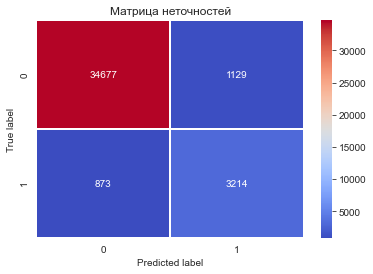

In [588]:
f1_log,roc_log = score(log_model,tf_idf_test,t_test)
matrix(log_model,tf_idf_test,t_test)

'Метрики качества модели F1: 0.9779411764705883'

'Оценка ROC-AUC: 1.0000'

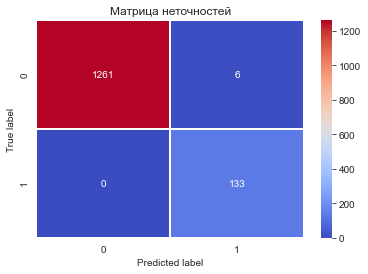

In [589]:
f1_log_bert,roc_log_bert = score(log_model_bert,f_train_bert,t_train_bert)
matrix(log_model_bert,f_train_bert,t_train_bert)

'Метрики качества модели F1: 0.35826034124854433'

'Оценка ROC-AUC: 0.8795'

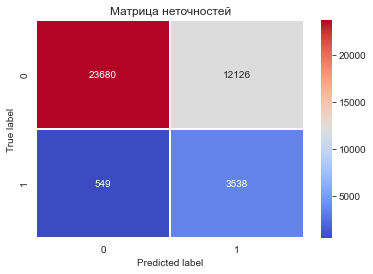

In [590]:
f1_forest,roc_forest = score(forest_model,tf_idf_test,t_test)
matrix(forest_model,tf_idf_test,t_test)

'Метрики качества модели F1: 0.903448275862069'

'Оценка ROC-AUC: 0.9966'

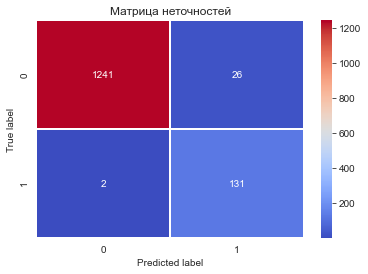

In [591]:
f1_forest_bert,roc_forest_bert = score(forest_model_bert,f_train_bert,t_train_bert)
matrix(forest_model_bert,f_train_bert,t_train_bert)

'Метрики качества модели F1: 0.7330266276313955'

'Оценка ROC-AUC: 0.9320'

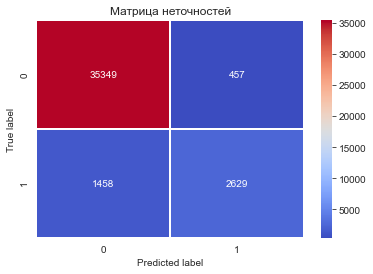

In [592]:
f1_gbc,roc_gbc = score(gbc_model,tf_idf_test,t_test)
matrix(gbc_model,tf_idf_test,t_test)

'Метрики качества модели F1: 1.0'

'Оценка ROC-AUC: 1.0000'

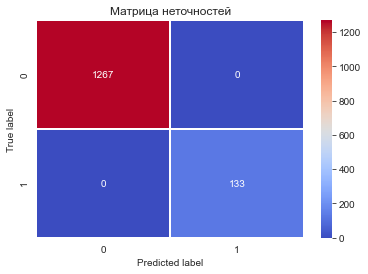

In [593]:
f1_gbc_bert,roc_gbc_bert = score(gbc_model_bert,f_train_bert,t_train_bert)
matrix(gbc_model_bert,f_train_bert,t_train_bert)

'Метрики качества модели F1: 0.7509964830011723'

'Оценка ROC-AUC: 0.9595'

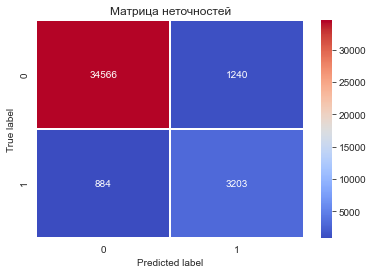

In [594]:
f1_sgd,roc_sgd = score(sgd_model,tf_idf_test,t_test)
matrix(sgd_model,tf_idf_test,t_test)

'Метрики качества модели F1: 0.9399293286219081'

'Оценка ROC-AUC: 0.9933'

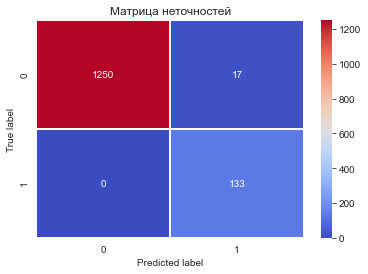

In [595]:
f1_sgd_bert,roc_sgd_bert = score(sgd_model_bert,f_train_bert,t_train_bert)
matrix(sgd_model_bert,f_train_bert,t_train_bert)

In [599]:
result_all = pd.DataFrame(
    {'Использованые модели': ['Const','Logistic','RandomForest','GradientBoosting','SGD'],
     'Лучшая метрика F1':[f1_const,f1_log,f1_forest, f1_gbc,f1_sgd],
     'Лучшая метрика ROC-AUC':[0,roc_log,roc_forest, roc_gbc, roc_sgd],
     'Лучшая метрика F1 на DistilBert':[f1_const,f1_log_bert,f1_forest_bert, f1_gbc_bert,f1_sgd_bert],
     'Лучшая метрика ROC-AUC на DistilBert':[0,roc_log_bert,roc_forest_bert, roc_gbc_bert, roc_sgd_bert]}
)
result_all.sort_values(by='Лучшая метрика F1',ascending = False)

,Использованые модели,Лучшая метрика F1,Лучшая метрика ROC-AUC,Лучшая метрика F1 на DistilBert,Лучшая метрика ROC-AUC на DistilBert
1,Logistic,0.762515,0.962474,0.977941,1.000000
4,SGD,0.750996,0.959500,0.939929,0.993291
3,GradientBoosting,0.733027,0.932049,1.000000,1.000000
2,RandomForest,0.358260,0.879510,0.903448,0.996635
0,Const,0.185857,0.000000,0.185857,0.000000


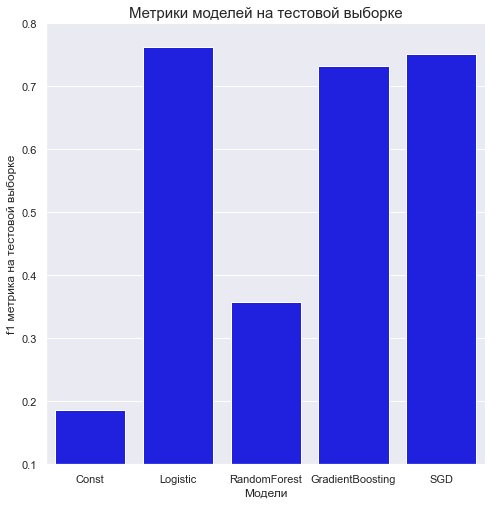

In [674]:
sns.set(style="darkgrid")
sns.catplot(x='Использованые модели', y='Лучшая метрика F1', data=result_all, kind="bar", color='blue',size=7)
plt.xlabel('Модели')
plt.ylabel('f1 метрика на тестовой выборке')
plt.ylim(0.10,0.8)
plt.title('Метрики моделей на тестовой выборке', size=15)
plt.show();

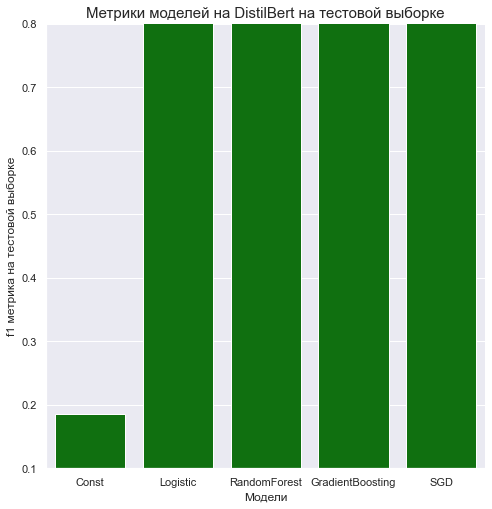

In [675]:
sns.catplot(x='Использованые модели', y='Лучшая метрика F1 на DistilBert', data=result_all, kind="bar", size=7,color='green')
plt.xlabel('Модели')
plt.ylabel('f1 метрика на тестовой выборке')
plt.ylim(0.10,0.8)
plt.title('Метрики моделей на DistilBert на тестовой выборке', size=15)
plt.show();

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> 
    Лучший результат выборки векторизированной с помощью модели TF-IDF получила модель LogisticRegression показала метрику F1  на тестовой выборке  0.7625, оценка ROC-AUC составила 0.962474. По показателям матрицы неточности видим что модель предсказывает верно больше истино-положительные предсказания чем истино отрицательные предсккзания(похоже на реальные данные).
    Лучший результат выборки векторизированной с помощью модели DistilBert получила модель GradientBoostingClassifier показала метрику F1  на тестовой выборке  1.0000, оценка ROC-AUC составила 1.0000. По показателям матрицы неточности видим что модель не ошибается вообще.
    Худший результат на обеих выборках показала модель RandomForestClassifier показала метрику F1  на тестовой выборке  0.358260 и 0.903448	 соотвественно.
    

'Оценка ROC-AUC: 0.9625'

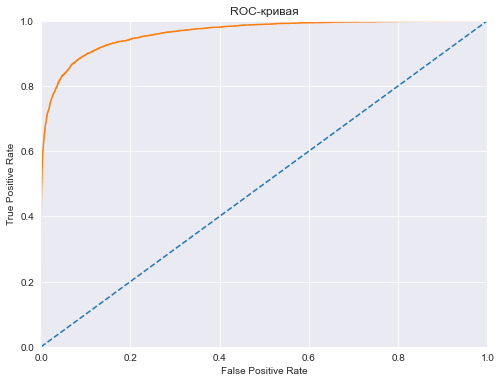

In [602]:
# сравним нашу метрику F1 с площадью под ROC-кривой, 
probabilities_test = log_model.predict_proba(tf_idf_test)
probabilities_one_test = probabilities_test[:, 1]
display("Оценка ROC-AUC: {:.4f}".format(roc_auc_score(t_test, probabilities_one_test)))
# чтобы определить как сильно наша модель отличается от случайной модели 
fpr, tpr, thresholds = roc_curve(t_test, probabilities_one_test)
# Построим график ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели (выглядит как прямая)
plt.plot(fpr, tpr, )
plt.ylim([0.0, 1.0]) #   установить границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.xlabel('False Positive Rate') # примените функции plt.xlabel() и plt.ylabel(), чтобы
plt.ylabel('True Positive Rate') # подписать оси "False Positive Rate" и "True Positive Rate" 
plt.title('ROC-кривая')
plt.show();

<a href='#0.0'>Содержание'</a>

# 3. Выводы <a id='1.8'></a>

### Думаю результаты полученные на моделях с выборкой векторизированной с помощью модели DistilBert не совсем реальные, так как выборка была уменьшенна из-за нехватки мощностей ПК, но можно предположить, что результаты целой выборки будут стремиться к ним. Так же можно было и дальше экспериментировать с гиперпараметрами докручивая их и углубиться в балансировку классов различными методами. Так же в случае использования Bert а не DistilBert мы бы получили лучшее качество. Мы получили модель со значением метрики качества F1 не меньше 0.75. и это модель LogisticRegression, но в случае реального заказа я бы рекомендовал заказчику использовать модели, выборки которых векторизированы с помощью модели DistilBert Bert

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны